# NBA Winner Classifier

## Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
import dataframe_image as dfi

## Setup

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [39]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [40]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [41]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [42]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [43]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="prec", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-prec")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [44]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [45]:
metrics = ['prec', 'bal_acc', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='prec', filter_val=None):
    second_metric = 'bal_acc' if metric == 'prec' else 'prec'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model.isin(filter_val))
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [46]:
season_games = sg.load_season_games_dataset()

## Dataset


In [179]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [47]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

### Clean Data

In [48]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)
df.drop(df[df.G_PLAYED < 20].index, inplace = True)
print(df.shape)
utils.serialize_object('df', df)

(9599, 405)
0
(9461, 405)
(8372, 405)


In [53]:
df_styled = df[model_config.X_COLS_BEST_BORUTA].head(5)
to_image = df_styled.T
dfi.export(to_image, 'clf_fs_first_5_games.png')

df_styled = df[model_config.X_COLS_BEST_BORUTA].tail(5)
to_image = df_styled.T
dfi.export(to_image, 'clf_fs_last_5_games.png')

## Experiments

### Setup

In [49]:
X_features = model_config.X_COLS_BEST_BORUTA

In [50]:
exp_prefix = "clf_"
exp_suffix = "fs"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"

exp_X_columns = model_config.X_COLS_BEST_BORUTA
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [51]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [217]:
## RandomForest
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

x_cols = model_config.X_COLS_NO_HIGH_CORR
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X_boruta = df_sscv[x_cols]
y_boruta = df_sscv[TARGET]

folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 500, max_iter=200, random_state = 0)
list_selected_features = []

for train_idx, test_idx in folds[-3:]:    
    X_train, X_test = X_boruta.loc[train_idx], X_boruta.loc[test_idx]
    y_train, y_test = y_boruta.loc[train_idx], y_boruta.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(x_cols)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

KeyboardInterrupt: 

In [ ]:
f_df = dict_to_list(folds_selected_features)

In [ ]:
f_df.sort_values(by=[1, 0], ascending=False)
final_selected_features = f_df[f_df[1] > 1][0].unique()
#final_selected_features = list(f_df[0].unique())

In [ ]:
# best_boruta = list_selected_features[3]
# sorted(best_boruta)
# best_boruta
sorted(final_selected_features)
#final_selected_features
final_selected_features = \
[
 'BLK_MEAN_HOME',
 'BLK_MEAN_AWAY',
 'FG3_PCT_MEAN_HOME',
 'FG3_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_HOME',
 'HOME_AST_L10',
 'HOME_AST_MEAN',
 'HOME_AST_ML10',
 'HOME_FG3_PCT_MEAN',
 'HOME_FG_PCT_L10',
 'HOME_FG_PCT_MEAN',
 'HOME_FG_PCT_ML10',
 'HOME_PF_MEAN',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'HOME_PTS_L10',
 'HOME_PTS_MEAN',
 'HOME_PYTHAGOREAN_EXPECTATION',
 'HOME_PYTHAGOREAN_EXPECTATION_CUM_ML10',
 'HOME_PYTHAGOREAN_EXPECTATION_L10',
 'HOME_REB_MEAN',
 'PLUS_MINUS_L10_AWAY',
 'PLUS_MINUS_L10_HOME',
 'PLUS_MINUS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_AWAY',
 'PTS_MEAN_HOME',
 'PTS_ML10_HOME',
 'PTS_ML10_AWAY'
]

#### Test best features

In [ ]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]
    models = utils_exp.get_clf_models()

    experiment_name = f"{exp_prefix}2_seasons_boruta_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))

In [121]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,8))
exp_df = get_results_df()
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget
#exp_df.sort_values(by=["bal_acc_mean"], ascending=False)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

#### Test specific best feature set

In [16]:
#features = list_selected_features[5]
features = model_config.X_COLS_NO_HIGH_CORR
X_boruta = df_sscv[features]
y_boruta = df_sscv[TARGET]
models = utils_exp.get_clf_models()

experiment_name = f"{exp_prefix}2_seasons_boruta_fsf"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_fsf
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
1,clf_2_seasons_boruta_fsf,KNN,0.681999,0.023866,0.624220,0.020390
4,clf_2_seasons_boruta_fsf,RF,0.676674,0.020242,0.627080,0.019150
3,clf_2_seasons_boruta_fsf,SVM,0.675359,0.029767,0.625867,0.028115
0,clf_2_seasons_boruta_fsf,L2R,0.674783,0.027254,0.626146,0.024149
5,clf_2_seasons_boruta_fsf,XGB,0.656815,0.019491,0.599434,0.014473
6,clf_2_seasons_boruta_fsf,LGB,0.656575,0.019315,0.599821,0.014880
2,clf_2_seasons_boruta_fsf,DT,0.629300,0.008158,0.553703,0.009309


#### Test custom best feature set

In [254]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_custom
Done


,exp_name,model,precision_mean,precision_std
73,clf_2_seasons_boruta_custom,SVM,0.760366,0.011854
70,clf_2_seasons_boruta_custom,LR,0.760026,0.011737
74,clf_2_seasons_boruta_custom,RF,0.755667,0.010853
75,clf_2_seasons_boruta_custom,XGB,0.748373,0.005121
76,clf_2_seasons_boruta_custom,LGB,0.743551,0.005716
72,clf_2_seasons_boruta_custom,DT,0.697575,0.008015
71,clf_2_seasons_boruta_custom,KNN,0.684097,0.016000


### Experiment using 1 season

In [70]:
#### START EXPERIMENTS

experiment_name = f"{exp_prefix}1_season_{exp_suffix}"

In [71]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
0,clf_1_season_fs,L2R,0.687207,0.033343,0.639113,0.022627
3,clf_1_season_fs,SVM,0.682599,0.032628,0.633488,0.026323
1,clf_1_season_fs,KNN,0.681132,0.029070,0.623171,0.020850
4,clf_1_season_fs,RF,0.680350,0.030873,0.628408,0.022679
5,clf_1_season_fs,LGB,0.661334,0.024106,0.603438,0.017326
6,clf_1_season_fs,XGB,0.658628,0.031877,0.599335,0.025963
2,clf_1_season_fs,DT,0.648972,0.021526,0.574757,0.011308


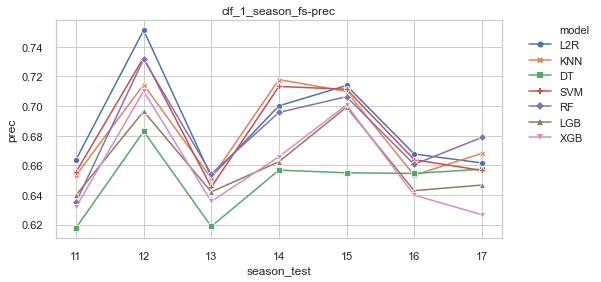

In [72]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [73]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10,1077,11,838
1,11,838,12,1078
2,12,1078,13,1076
3,13,1076,14,1075
4,14,1075,15,1076
5,15,1076,16,1075
6,16,1075,17,1077


### Experiment using StandardScaler

In [74]:
# experiment_name = f"{exp_prefix}scaled_data_{exp_suffix}"

In [75]:
# del_result_by(experiment_name)

# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])
# preprocessor = ColumnTransformer([
#         ('numerical', num_pipeline, exp_X_columns)
#     ], remainder='passthrough')
# #transformed_data = preprocessor.fit_transform(df)

# folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [76]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))


In [77]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment using MinMaxScaler

In [78]:
# experiment_name = f"{exp_prefix}minmax_data_{exp_suffix}"

In [79]:
# del_result_by(experiment_name)

# num_pipeline = Pipeline([
#     ('minmax_scaler', MinMaxScaler())
# ])
# preprocessor = ColumnTransformer([
#         ('numerical', num_pipeline, exp_X_columns)
#     ], remainder='passthrough')
# #transformed_data = preprocessor.fit_transform(df)

# folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [80]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,4))

In [81]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment: train: 2s; test: 1s

In [82]:
experiment_name = f"{exp_prefix}2_seasons_{exp_suffix}"

In [83]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)




Running experiment clf_2_seasons_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
10,clf_2_seasons_fs,SVM,0.694310,0.028135,0.646153,0.019470
7,clf_2_seasons_fs,L2R,0.691611,0.023004,0.644761,0.015656
11,clf_2_seasons_fs,RF,0.688612,0.017149,0.637988,0.020138
8,clf_2_seasons_fs,KNN,0.681927,0.029866,0.621714,0.025770
12,clf_2_seasons_fs,LGB,0.675119,0.018709,0.619409,0.021737
13,clf_2_seasons_fs,XGB,0.670233,0.022591,0.611579,0.016830
9,clf_2_seasons_fs,DT,0.648587,0.018615,0.574445,0.014759


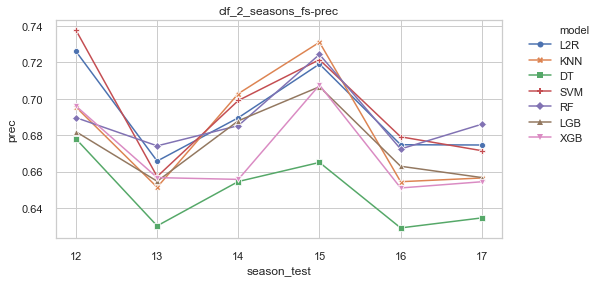

In [84]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [85]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11,1915,12,1078
1,11-12,1916,13,1076
2,12-13,2154,14,1075
3,13-14,2151,15,1076
4,14-15,2151,16,1075
5,15-16,2151,17,1077


### Experiment: train: 3s; test: 1s

In [86]:
experiment_name = f"{exp_prefix}3_seasons_{exp_suffix}"

In [87]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
17,clf_3_seasons_fs,SVM,0.687284,0.016294,0.644685,0.014982
14,clf_3_seasons_fs,L2R,0.685047,0.017137,0.644764,0.016414
18,clf_3_seasons_fs,RF,0.683279,0.014442,0.638247,0.013086
15,clf_3_seasons_fs,KNN,0.681655,0.023046,0.629487,0.019515
20,clf_3_seasons_fs,XGB,0.674051,0.017822,0.624169,0.018432
19,clf_3_seasons_fs,LGB,0.666926,0.017425,0.617059,0.018120
16,clf_3_seasons_fs,DT,0.647335,0.014505,0.578860,0.013180


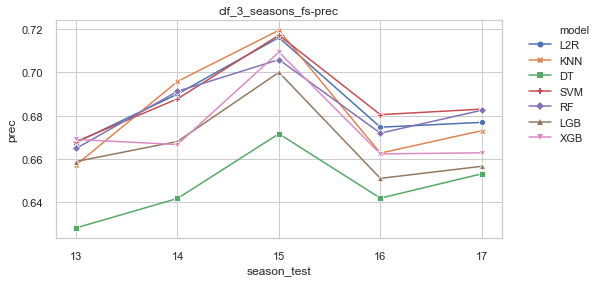

In [88]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [89]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10-11-12,2993,13,1076
1,11-12-13,2992,14,1075
2,12-13-14,3229,15,1076
3,13-14-15,3227,16,1075
4,14-15-16,3226,17,1077


### Experiment remove last 2q ; train: 2q ; test: 2q

In [90]:
experiment_name = f"{exp_prefix}2q_2q_rl2q_{exp_suffix}"

In [91]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.75, 1.0])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q_rl2q_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
21,clf_2q_2q_rl2q_fs,L2R,0.675586,0.040851,0.632551,0.018712
24,clf_2q_2q_rl2q_fs,SVM,0.666489,0.050195,0.622449,0.033758
22,clf_2q_2q_rl2q_fs,KNN,0.665716,0.042063,0.611343,0.032822
25,clf_2q_2q_rl2q_fs,RF,0.659609,0.040677,0.610943,0.029760
27,clf_2q_2q_rl2q_fs,XGB,0.651670,0.042586,0.594804,0.029009
26,clf_2q_2q_rl2q_fs,LGB,0.647692,0.041655,0.592920,0.028882
23,clf_2q_2q_rl2q_fs,DT,0.622482,0.044521,0.557135,0.021253


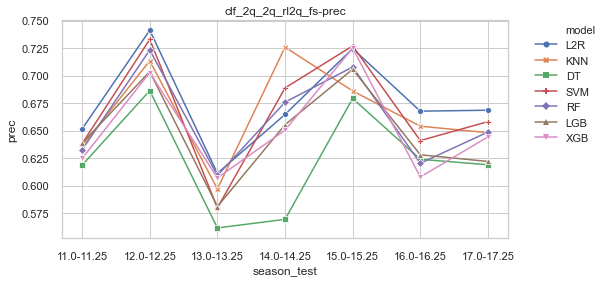

In [92]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [93]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25,538,11.0-11.25,419
1,11.0-11.25,419,12.0-12.25,539
2,12.0-12.25,539,13.0-13.25,538
3,13.0-13.25,538,14.0-14.25,537
4,14.0-14.25,537,15.0-15.25,538
5,15.0-15.25,538,16.0-16.25,537
6,16.0-16.25,537,17.0-17.25,538


### Experiment remove first 2q ;train: 2q ; test: 2q

In [94]:
experiment_name = f"{exp_prefix}2q_2q_rf2q_{exp_suffix}"

In [95]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q_rf2q_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
32,clf_2q_2q_rf2q_fs,RF,0.706004,0.030421,0.646421,0.027351
29,clf_2q_2q_rf2q_fs,KNN,0.704286,0.031278,0.641828,0.027034
31,clf_2q_2q_rf2q_fs,SVM,0.703647,0.029578,0.643248,0.025378
28,clf_2q_2q_rf2q_fs,L2R,0.698188,0.030687,0.640230,0.025090
33,clf_2q_2q_rf2q_fs,LGB,0.683601,0.026511,0.616732,0.027085
34,clf_2q_2q_rf2q_fs,XGB,0.681646,0.031784,0.612650,0.032132
30,clf_2q_2q_rf2q_fs,DT,0.658753,0.032812,0.574861,0.027512


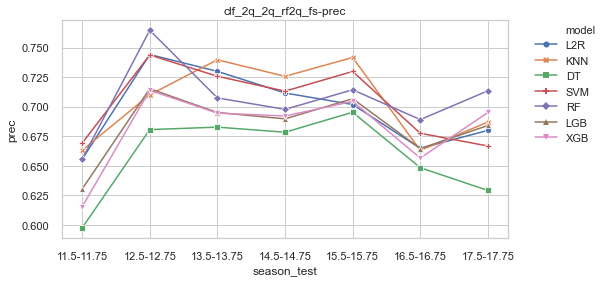

In [96]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [97]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75,539,11.5-11.75,419
1,11.5-11.75,419,12.5-12.75,539
2,12.5-12.75,539,13.5-13.75,538
3,13.5-13.75,538,14.5-14.75,538
4,14.5-14.75,538,15.5-15.75,538
5,15.5-15.75,538,16.5-16.75,538
6,16.5-16.75,538,17.5-17.75,539


### Experiment train: remove last 1q ; 3q ; test: 1q ; step: 3q

In [98]:
experiment_name = f"{exp_prefix}3q_1q_r1q_s3q_{exp_suffix}"

In [99]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, remove_quarters=[1.0], skip_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q_r1q_s3q_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
35,clf_3q_1q_r1q_s3q_fs,L2R,0.676744,0.046887,0.642397,0.022343
39,clf_3q_1q_r1q_s3q_fs,RF,0.672837,0.045726,0.630895,0.033941
36,clf_3q_1q_r1q_s3q_fs,KNN,0.665025,0.037908,0.619647,0.026704
38,clf_3q_1q_r1q_s3q_fs,SVM,0.662935,0.043255,0.625234,0.030736
40,clf_3q_1q_r1q_s3q_fs,LGB,0.642469,0.047577,0.595286,0.028049
41,clf_3q_1q_r1q_s3q_fs,XGB,0.637065,0.038231,0.588960,0.018093
37,clf_3q_1q_r1q_s3q_fs,DT,0.626790,0.043926,0.568729,0.014832


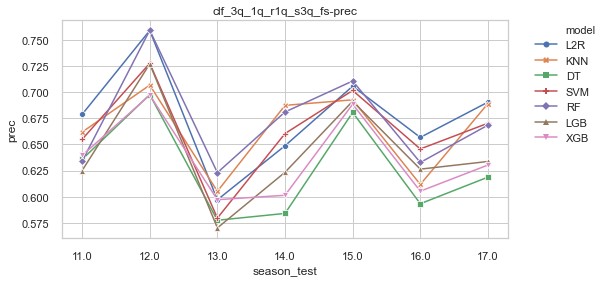

In [100]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [101]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,807,11.0,209
1,11.0-11.25-11.5,628,12.0,269
2,12.0-12.25-12.5,808,13.0,269
3,13.0-13.25-13.5,807,14.0,268
4,14.0-14.25-14.5,806,15.0,269
5,15.0-15.25-15.5,807,16.0,268
6,16.0-16.25-16.5,806,17.0,269


### Experiment train: 3q ; test: 1q ; step: 3q

In [102]:
experiment_name = f"{exp_prefix}3q_1q_3s_{exp_suffix}"

In [103]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q_3s_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
43,clf_3q_1q_3s_fs,KNN,0.739027,0.032819,0.664013,0.024198
46,clf_3q_1q_3s_fs,RF,0.725124,0.024881,0.660096,0.029574
42,clf_3q_1q_3s_fs,L2R,0.713366,0.029468,0.649031,0.035671
45,clf_3q_1q_3s_fs,SVM,0.706110,0.032832,0.637440,0.036393
47,clf_3q_1q_3s_fs,LGB,0.700758,0.024522,0.625486,0.036495
48,clf_3q_1q_3s_fs,XGB,0.691979,0.019687,0.616236,0.027703
44,clf_3q_1q_3s_fs,DT,0.667254,0.033132,0.579284,0.030093


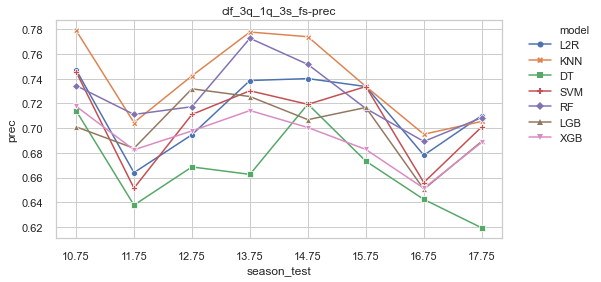

In [104]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8, 4))

In [105]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.0-10.25-10.5,807,10.75,270
1,11.0-11.25-11.5,628,11.75,210
2,12.0-12.25-12.5,808,12.75,270
3,13.0-13.25-13.5,807,13.75,269
4,14.0-14.25-14.5,806,14.75,269
5,15.0-15.25-15.5,807,15.75,269
6,16.0-16.25-16.5,806,16.75,269
7,17.0-17.25-17.5,807,17.75,270


### Experiment train: 4q ; test: 2q

In [106]:
# experiment_name = f"{exp_prefix}4q_2q_{exp_suffix}"

In [107]:
# del_result_by(experiment_name)

# folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
# params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
# names, results = utils_exp.run_experiment(*params)
# results_total.append((experiment_name, results))

# print_prettier_exp_results(experiment_name)

In [108]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(30,10))

In [109]:
# utils.folds_to_df(folds, train_seasons, test_seasons)

### Experiment remove first 2q ; train: 4q ; test: 2q

In [110]:
experiment_name = f"{exp_prefix}4q_2q_rf2q_{exp_suffix}"

In [111]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q_rf2q_fs
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
52,clf_4q_2q_rf2q_fs,SVM,0.717557,0.020030,0.660653,0.022511
53,clf_4q_2q_rf2q_fs,RF,0.712877,0.015777,0.654562,0.024900
50,clf_4q_2q_rf2q_fs,KNN,0.712346,0.028174,0.647550,0.032069
49,clf_4q_2q_rf2q_fs,L2R,0.710490,0.023526,0.655428,0.020192
55,clf_4q_2q_rf2q_fs,XGB,0.703263,0.023687,0.638677,0.032676
54,clf_4q_2q_rf2q_fs,LGB,0.686386,0.020014,0.617291,0.022816
51,clf_4q_2q_rf2q_fs,DT,0.655661,0.031971,0.570811,0.037315


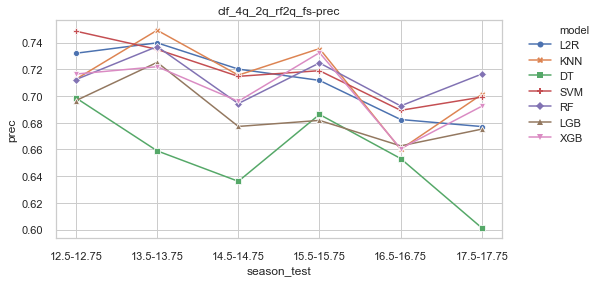

In [112]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [113]:
utils.folds_to_df(folds, train_seasons, test_seasons)

,train_seasons,train_samples_size,test_seasons,test_samples_size
0,10.5-10.75-11.5-11.75,958,12.5-12.75,539
1,11.5-11.75-12.5-12.75,958,13.5-13.75,538
2,12.5-12.75-13.5-13.75,1077,14.5-14.75,538
3,13.5-13.75-14.5-14.75,1076,15.5-15.75,538
4,14.5-14.75-15.5-15.75,1076,16.5-16.75,538
5,15.5-15.75-16.5-16.75,1076,17.5-17.75,539


### Experiments comparison

In [114]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [115]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [116]:
ba_df = exp_df[['exp_name', 'model',
       'prec_mean', 'prec_std', 'bal_acc_mean', 'bal_acc_std']]

In [117]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [118]:
ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:10].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
0,clf_3q_1q_3s_fs,KNN,0.739027,0.032819,0.664013,0.024198
1,clf_3q_1q_3s_fs,RF,0.725124,0.024881,0.660096,0.029574
2,clf_4q_2q_rf2q_fs,SVM,0.717557,0.020030,0.660653,0.022511
3,clf_3q_1q_3s_fs,L2R,0.713366,0.029468,0.649031,0.035671
4,clf_4q_2q_rf2q_fs,RF,0.712877,0.015777,0.654562,0.024900
5,clf_4q_2q_rf2q_fs,KNN,0.712346,0.028174,0.647550,0.032069
6,clf_4q_2q_rf2q_fs,L2R,0.710490,0.023526,0.655428,0.020192
7,clf_3q_1q_3s_fs,SVM,0.706110,0.032832,0.637440,0.036393
8,clf_2q_2q_rf2q_fs,RF,0.706004,0.030421,0.646421,0.027351
9,clf_2q_2q_rf2q_fs,KNN,0.704286,0.031278,0.641828,0.027034


### Plot experiment results

In [72]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

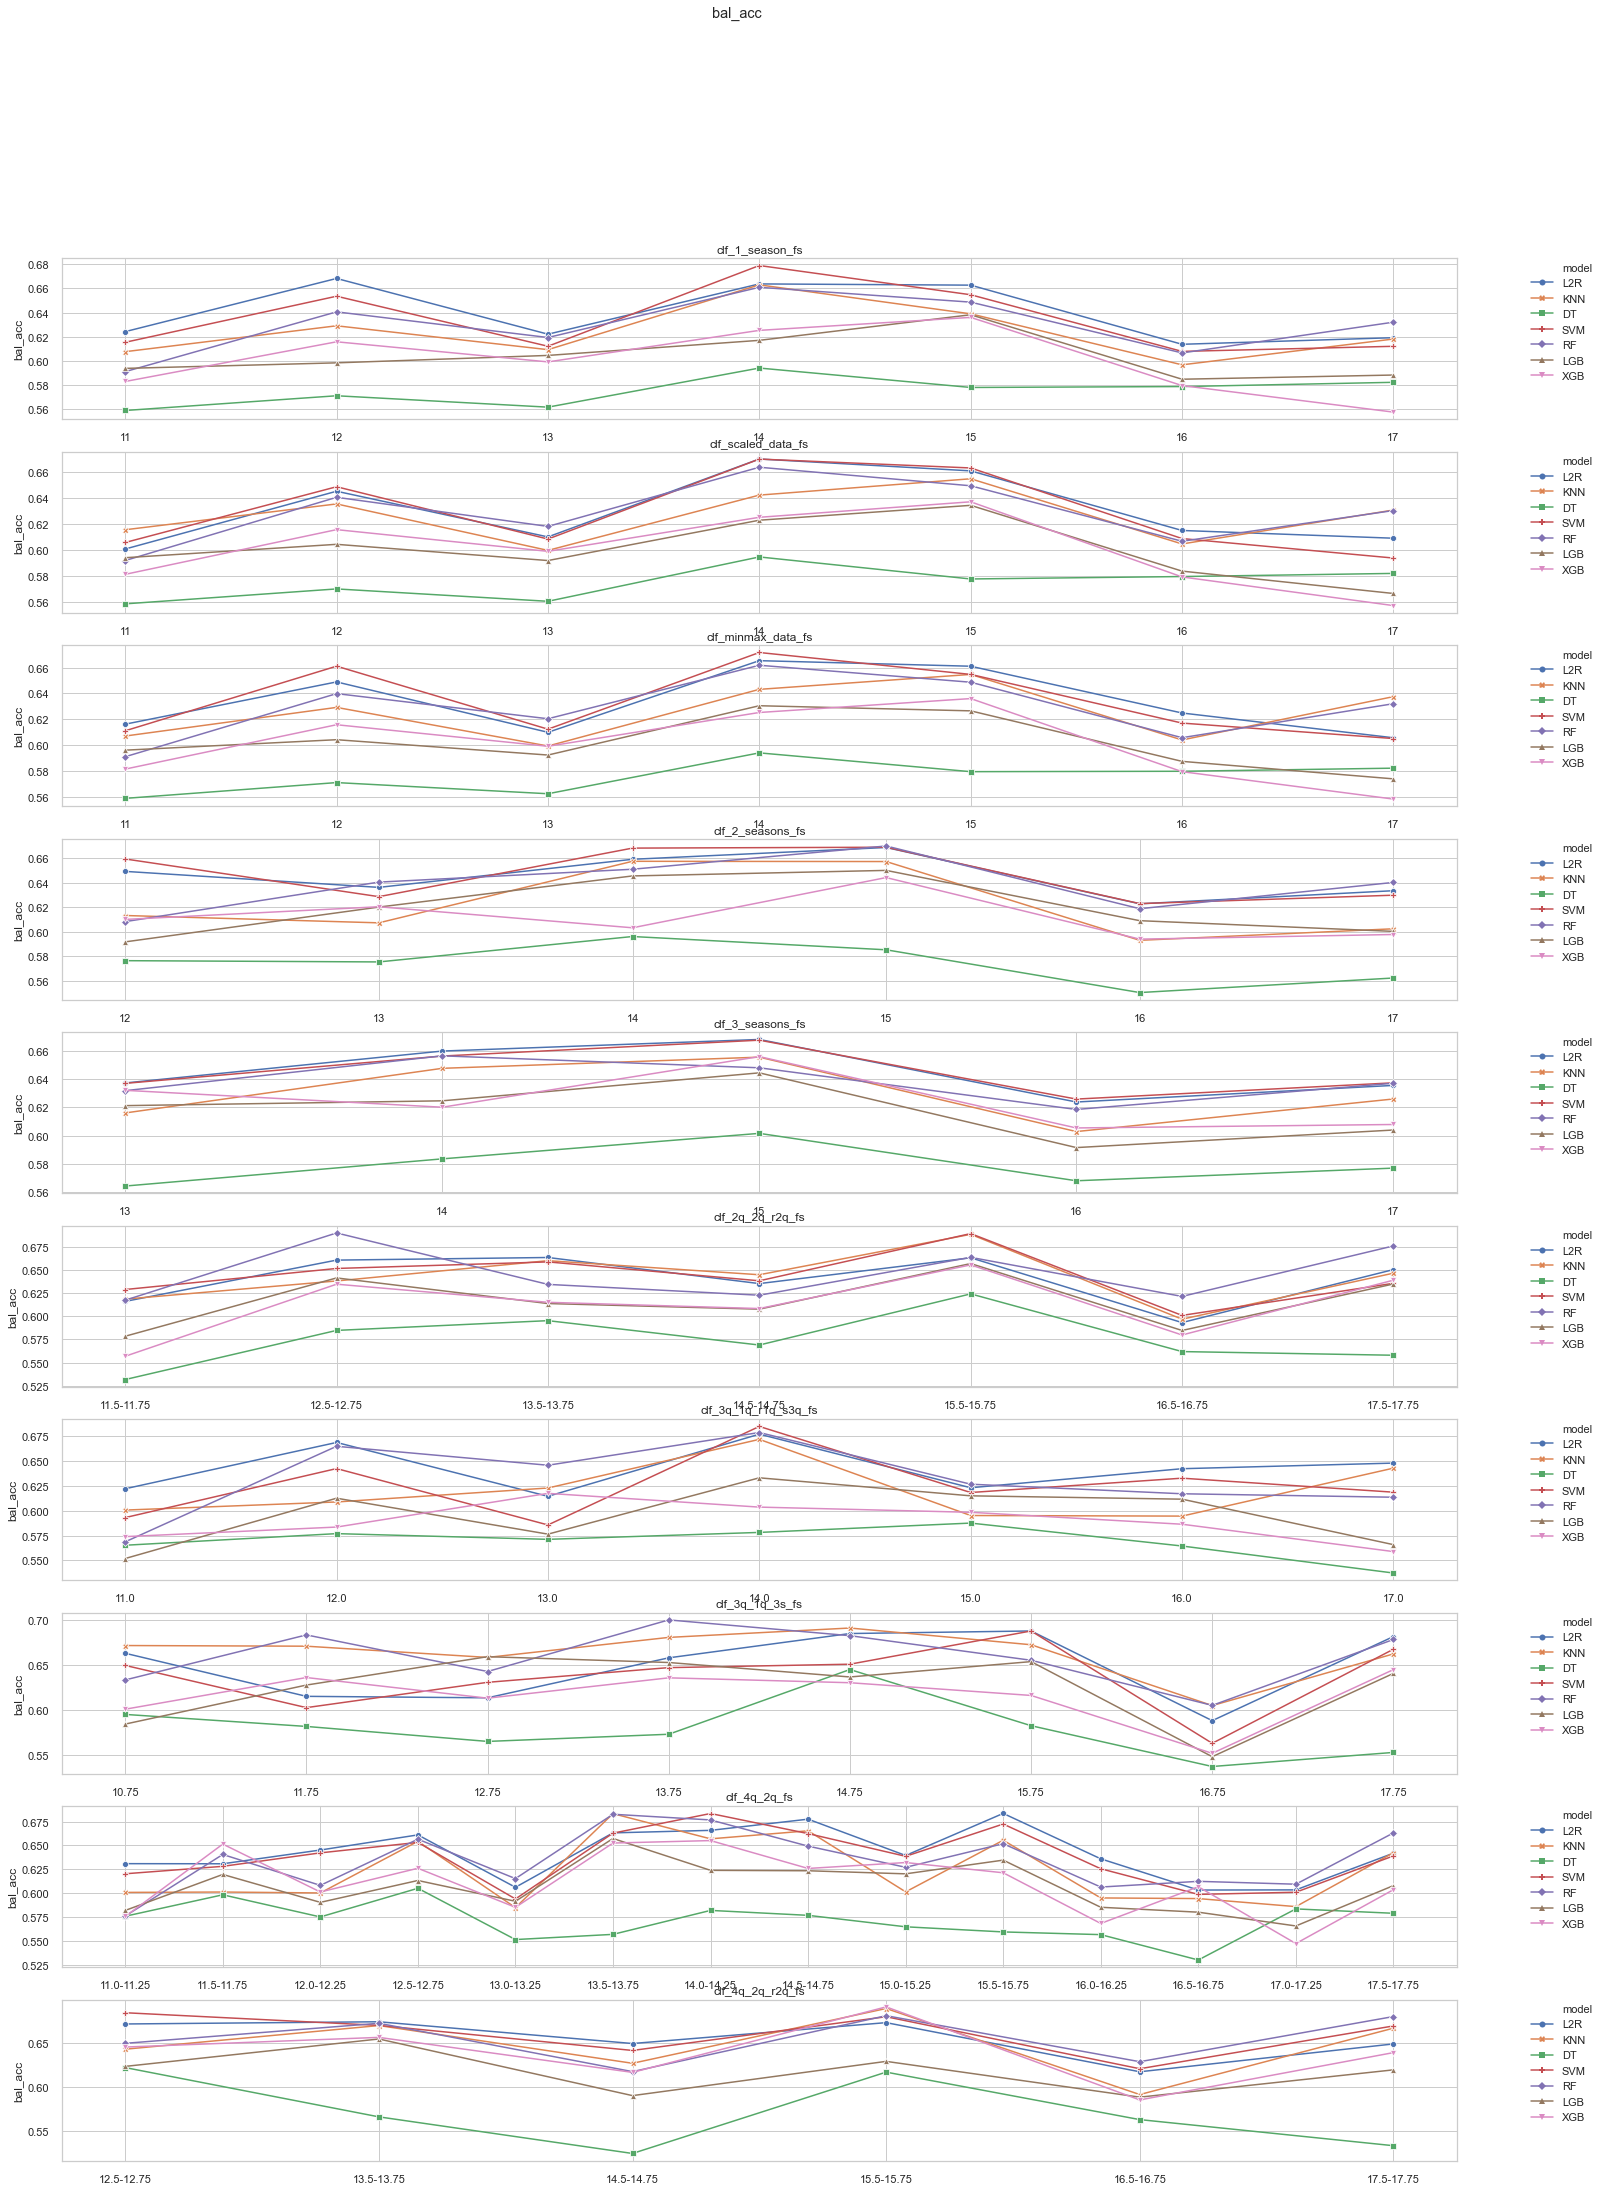

In [73]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

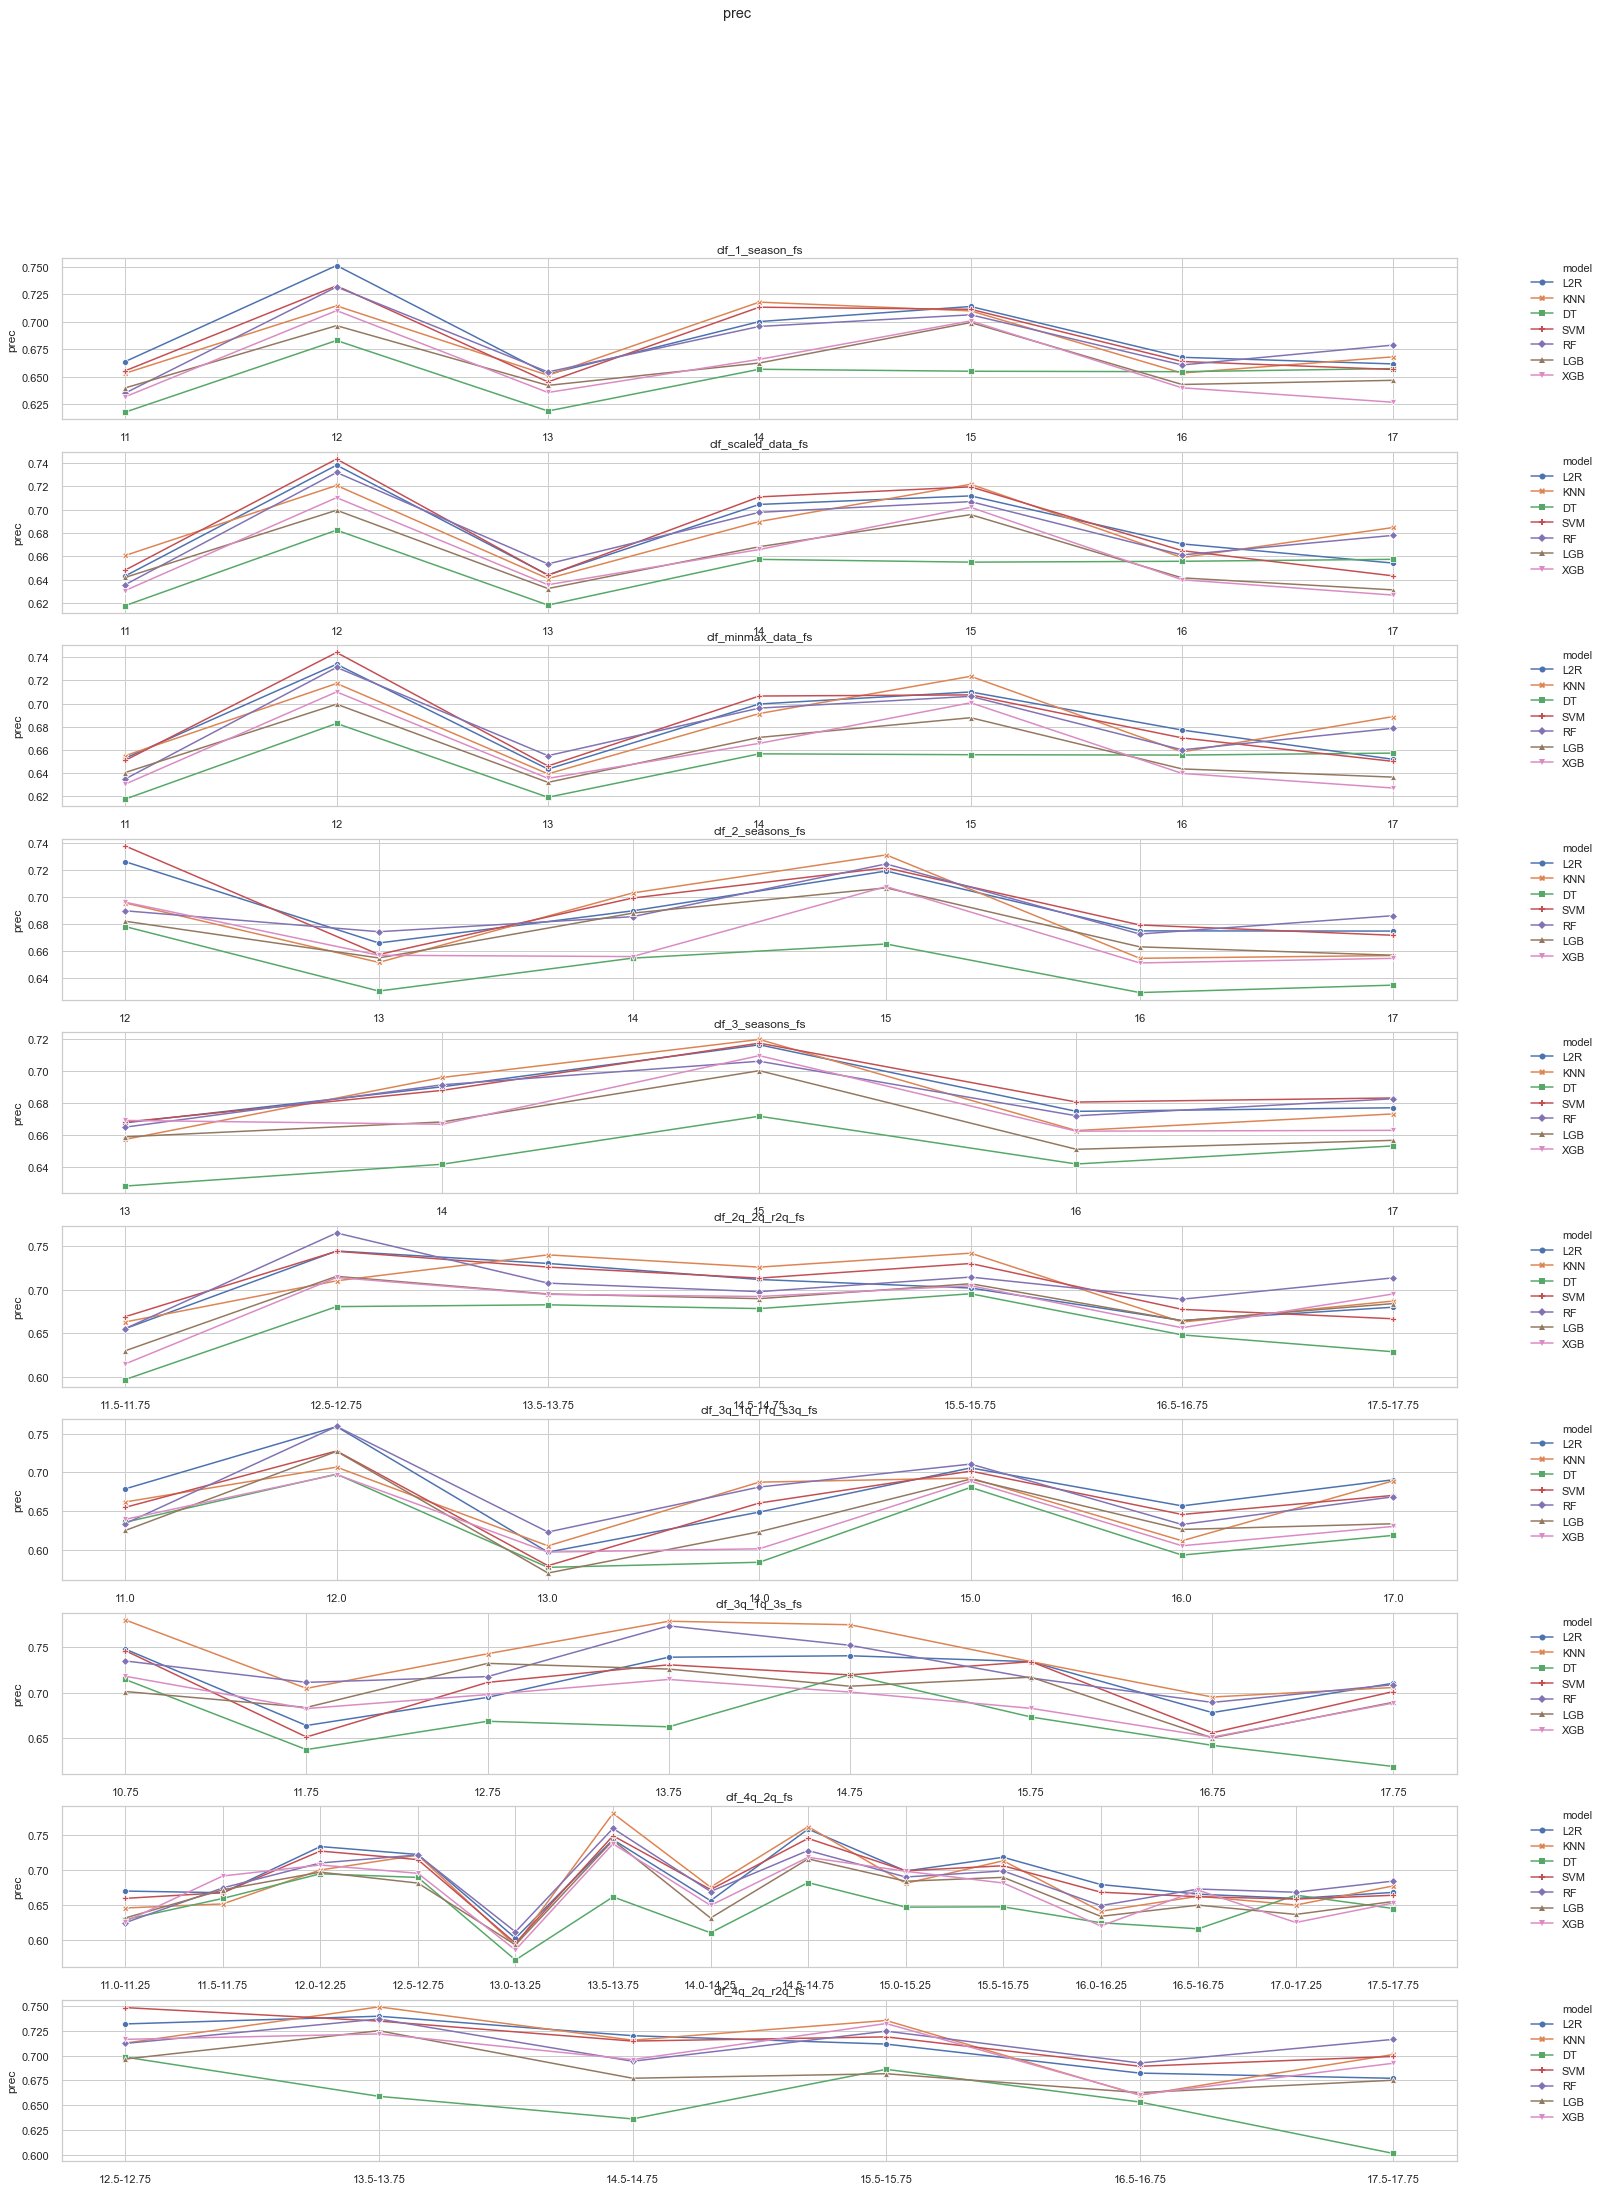

In [74]:
utils.plot_to_compare_experiments(
    results_total,
    metric="prec",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

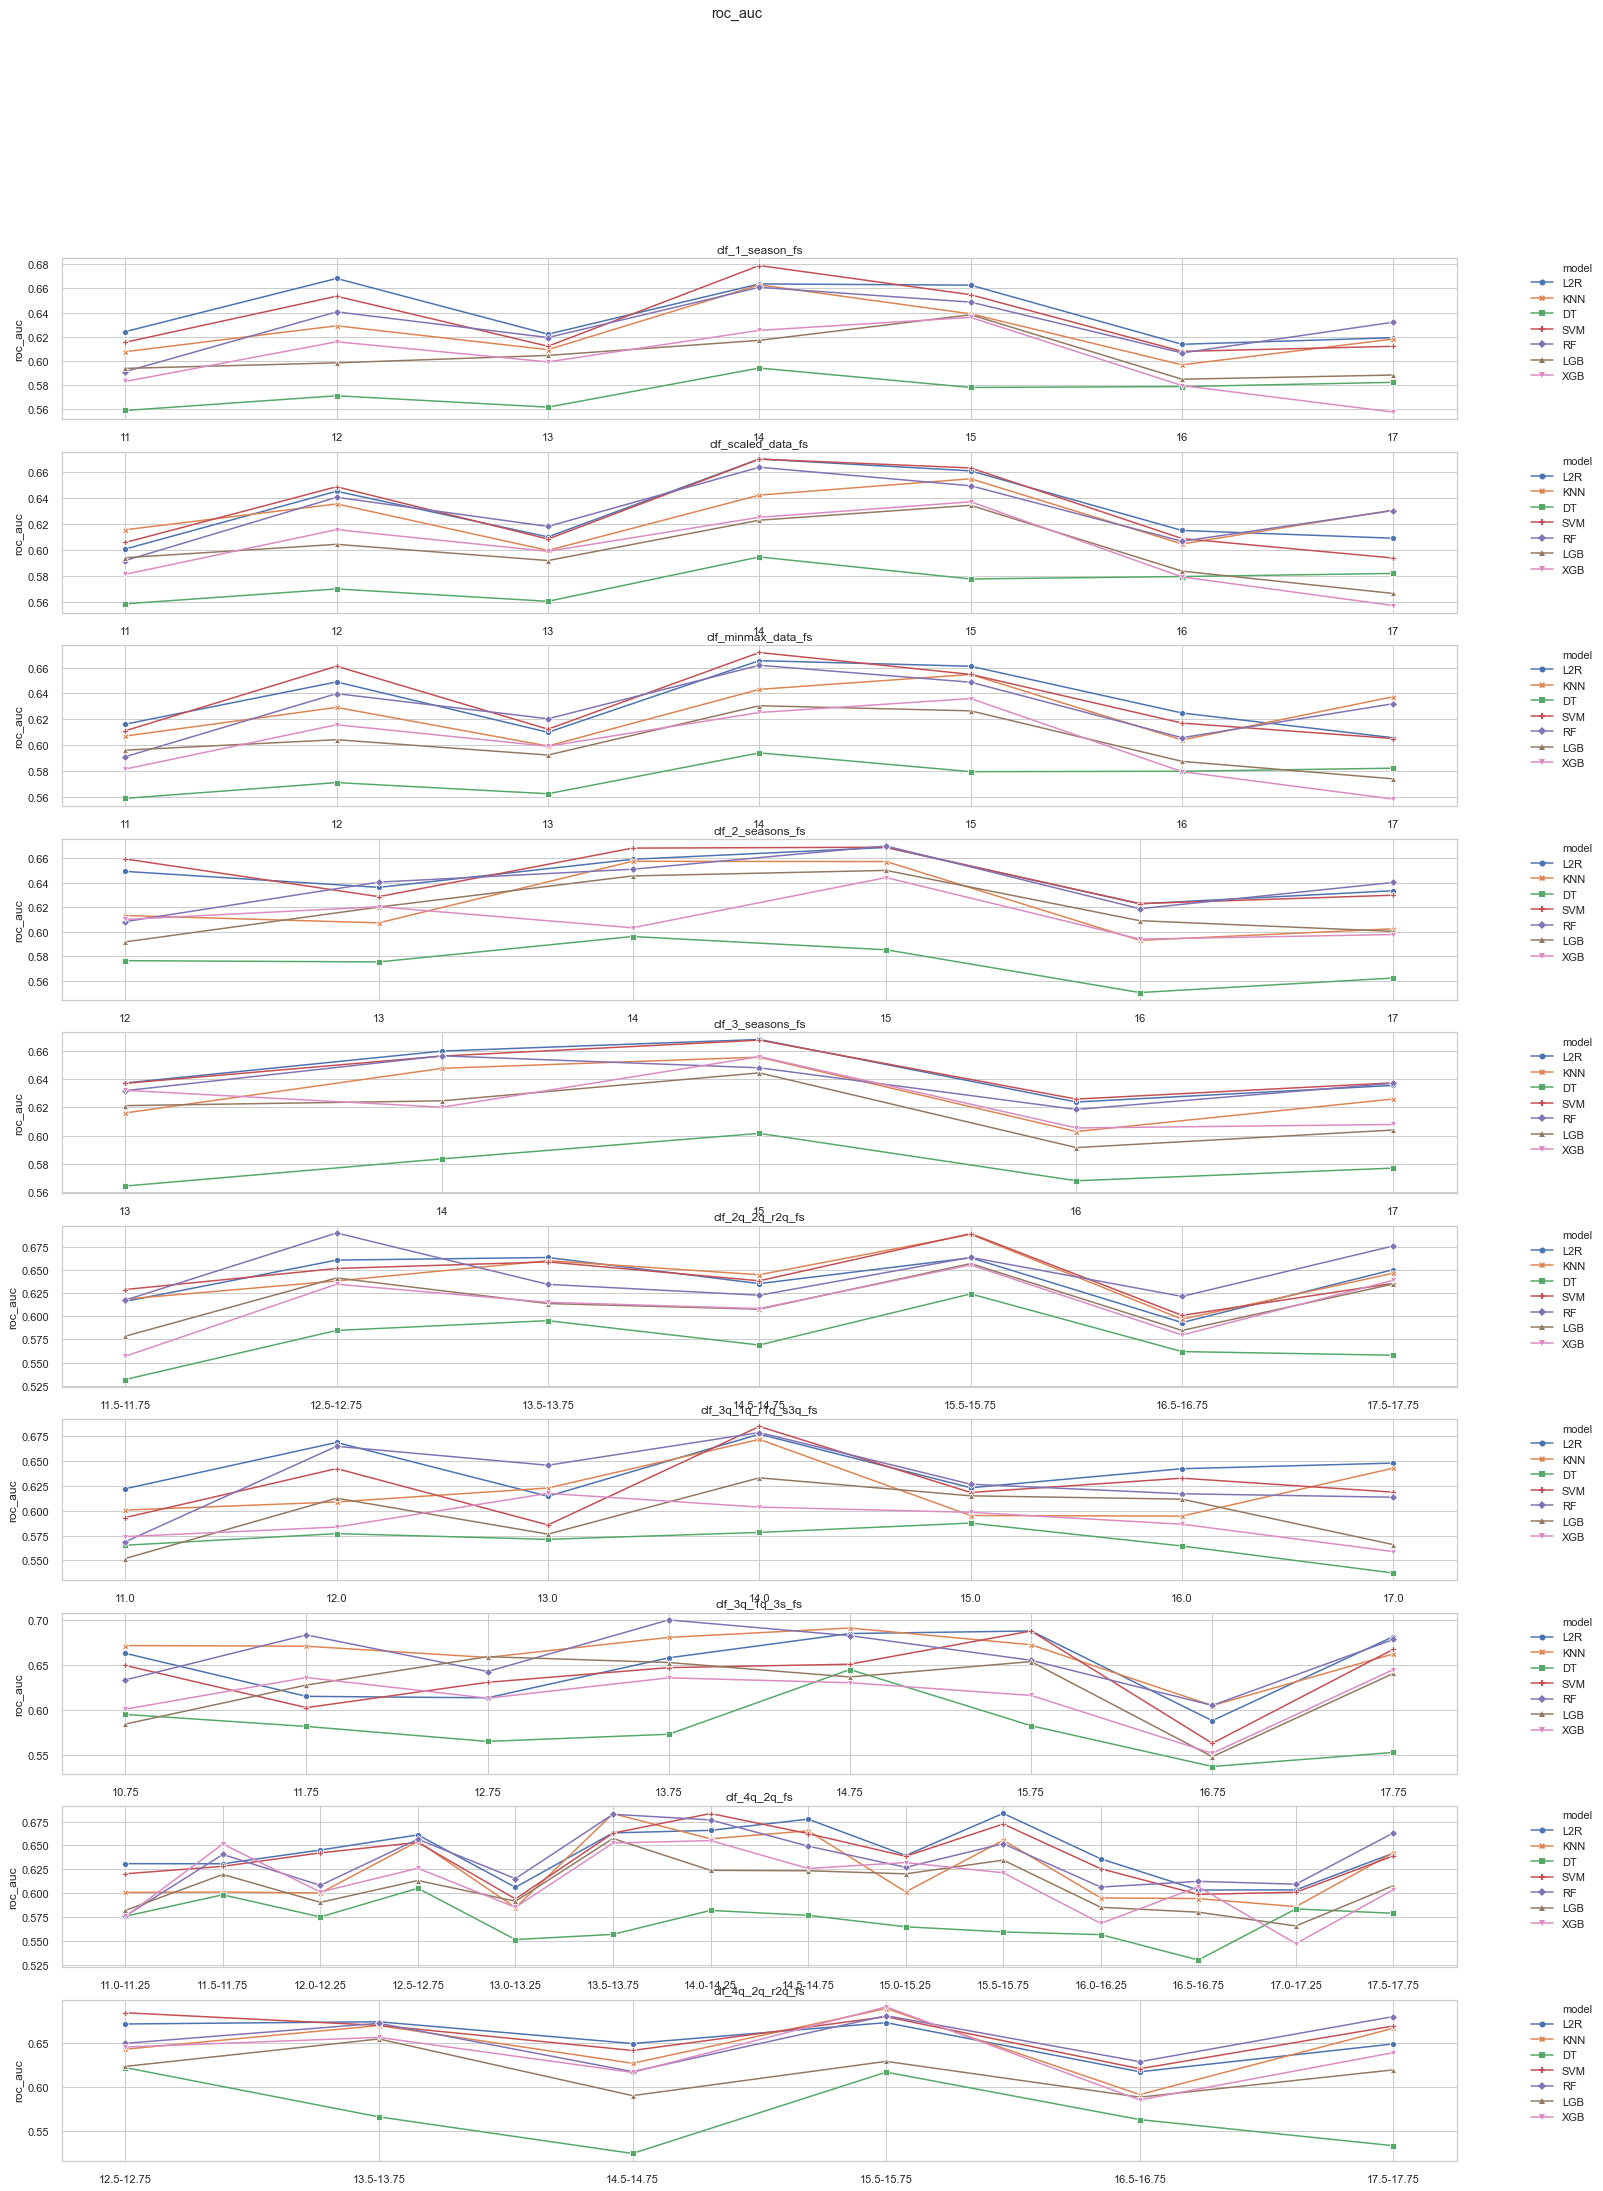

In [75]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)

### Optimization

#### Imports

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, \
        balanced_accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hpsklearn import HyperoptEstimator
import hpsklearn
from hyperopt.pyll import scope, as_apply
from hyperopt import SparkTrials, STATUS_OK

#### Dataset

In [18]:
op_df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]

##### Seasons

In [19]:
op_df.SEASON.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

##### Clean Data

In [20]:
print(op_df.shape)
op_df = op_df.dropna()
print(op_df.isnull().sum().sum())
print(op_df.isna().sum().sum())
print(op_df.shape)

(9599, 261)
0
0
(9461, 261)


#### setup

In [21]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_op"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

op_models = utils_exp.get_clf_models()

op_sscv = utils.SeasonSeriesSplit(op_df)
op_df_sscv = op_sscv.get_df()
op_X = op_df_sscv[exp_X_columns]
op_y = op_df_sscv[TARGET]

#### Utils

In [22]:
def walk_forward_val_mean_score(input_model):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        pipeline = Pipeline(steps=[
                ('model', input_model)])
        
        model = pipeline
        fit_info = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_results.append(balanced_accuracy_score(y_true, y_pred)) 

    return np.mean(metric_results)  


def walk_forward_sklearn(estim):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        estim.fit(X_train, y_train)
        print(estim.score(X_test, y_test))
        print(estim.best_model())

#### Optimization

In [23]:
folds, train_seasons, test_seasons = op_sscv.split(train_size=2, test_size=1)

In [24]:
# name = 'clf'
# models = [
#     #hpsklearn.svc(name + '.SVM'),
#     #svc_linear
#     #hpsklearn.random_forest(name + '.RF'),
#     #hpsklearn.xgboost_classification(name + '.XGB'),
#     #hpsklearn.lightgbm_classification(name + '.LGB')
#     hpsklearn.svc_linear(name + 'SVM')
# ]


# estim = HyperoptEstimator(classifier=hp.choice('%s' % name, models),
#                           #preprocessing=hpsklearn.any_preprocessing('my_pre'),
#                           preprocessing=None,
#                           algo=tpe.suggest,
#                           max_evals=50,
#                           trial_timeout=120)



# for train_idx, test_idx in folds:
#     X_train, X_test = X.loc[train_idx], X.loc[test_idx]
#     y_train, y_test = y.loc[train_idx], y.loc[test_idx]
#     y_true = y_test
#     estim.fit(X_train, y_train)
#     estim.score(X_test, y_test)

# print(estim.best_model())

#### LGB

In [31]:
space = {
    'max_depth': scope.int(hp.uniform('max_depth', 1, 11)),
    'num_leaves': scope.int(hp.uniform('num_leaves', 2, 121)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 6000, 200)),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': scope.int(hp.loguniform('min_child_weight', np.log(1), np.log(100))),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
    #boosting_type: hp.choice(name, ['gbdt', 'dart', 'goss'])
    'boosting_type': hp.choice('boosting_type', ['gbdt'])
}

default_hiperparameters = {
    'objective': 'binary',
    #'random_state': 0
}

def objective(space):
    print(space)
    hiperparameters = {**default_hiperparameters, **space}
    model = lgb.LGBMClassifier(
        **hiperparameters
    )

    accuracy = walk_forward_val_mean_score(model)

    return {'loss': -accuracy, 'status': STATUS_OK }

spark_trials = SparkTrials(parallelism=4)
#trials = Trials()
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=150,
        trials=spark_trials,
        rstate=np.random.RandomState(seed=0),
        return_argmin=False
    )
best

100%|██████████| 150/150 [1:57:28<00:00, 46.99s/trial, best loss: -0.7318679777757647] 


Total Trials: 150: 150 succeeded, 0 failed, 0 cancelled.


{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6108224915520017,
 'colsample_bytree': 0.7991125058203208,
 'gamma': 0.0012626451163248382,
 'learning_rate': 0.0018545119732252533,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 3800,
 'num_leaves': 87,
 'reg_alpha': 0.2835687543880991,
 'reg_lambda': 1.2786968649636916,
 'subsample': 0.5660499077502952}

#### Experiment

In [39]:

op_model = [
#     ('SVM', SVC(C=0.012697068361313206, cache_size=512, degree=1, gamma='auto',
#     kernel='linear', max_iter=54006698.0, random_state=4,
#     tol=8.876549929680088e-05)),
#     ("LGB", lgb.LGBMClassifier(boosting_type='dart', colsample_bytree=0.5774517052371843,
#                learning_rate=0.001088309810177423, max_delta_step=0,
#                max_depth=9, min_child_weight=22, n_estimators=3200, n_jobs=1,
#                num_leaves=19, objective='binary',
#                reg_alpha=0.0009920138640525102, reg_lambda=2.593449218886441,
#                scale_pos_weight=1, seed=3, subsample=0.980626212446999)),
    ('LGB', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7911287100076613,
 'colsample_bytree': 0.8603649524735973,
 'gamma': 4.43302024049316,
 'learning_rate': 0.0009592641656631401,
 'max_depth': 3,
 'min_child_weight': 17,
 'n_estimators': 4000,
 'num_leaves': 72,
 'reg_alpha': 1.0620929521387056e-05,
 'reg_lambda': 1.3493051864867296,
 'subsample': 0.9099643557200597}
    )),
    ('LGB2', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7729132785100075,
 'colsample_bytree': 0.8237696281830607,
 'gamma': 0.02767717987305845,
 'learning_rate': 0.004301947480128295,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 1400,
 'num_leaves': 101,
 'reg_alpha': 0.0004447330199770369,
 'reg_lambda': 1.1974372235637603,
 'subsample': 0.6524249725030407}
    )),
    ('LGB3', lgb.LGBMClassifier(**
    {'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6108224915520017,
 'colsample_bytree': 0.7991125058203208,
 'gamma': 0.0012626451163248382,
 'learning_rate': 0.0018545119732252533,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 3800,
 'num_leaves': 87,
 'reg_alpha': 0.2835687543880991,
 'reg_lambda': 1.2786968649636916,
 'subsample': 0.5660499077502952})),
    ("XGB", xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9274316569938598, colsample_bynode=1,
              colsample_bytree=0.768350297812703, gamma=0.275559851080226,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00383884756104703, max_delta_step=0, max_depth=2,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=5600, n_jobs=1, num_parallel_tree=1, random_state=3,
              reg_alpha=1.6862525411636347e-05, reg_lambda=1.976163318531772,
              scale_pos_weight=1, seed=3, subsample=0.9990805503135648,
              tree_method='exact', validate_parameters=1, verbosity=None)),
    
    ("XGB2", xgb.XGBClassifier(**{'colsample_bylevel': 0.6377999154047157,
 'colsample_bytree': 0.9842293615322797,
 'gamma': 0.0005531486918297421,
 'learning_rate': 0.0007474569779455549,
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 4600,
 'reg_alpha': 0.011708580861937797,
 'reg_lambda': 2.0311282671384228,
 'subsample': 0.5680268128073964})
    )
]

model_names = ['LGB', 'XGB']

In [40]:
experiment_name = f"{exp_prefix}2_seasons_op"
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, op_model, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name[:-3], metric='prec', filter_val= names)
print_prettier_exp_results(experiment_name)
# 11	clf_2_seasons	SVM	0.760366	0.011854	0.728416	0.012863
    # 8	clf_2_seasons	L2R	0.760026	0.011737	0.728800	0.014623
# 12	clf_2_seasons	RF	0.758332	0.011720	0.724693	0.010767
# 13	clf_2_seasons	XGB	0.748373	0.005121	0.706205	0.006501
# 14	clf_2_seasons	LGB	0.743551	0.005716	0.702446	0.006115

#XGB	0.74998	0.00996	0.721646	


Running experiment clf_2_seasons_op
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
2,clf_2_seasons_op,LGB3,0.764682,0.008933,0.731868,0.011893
0,clf_2_seasons_op,LGB,0.764012,0.010939,0.731917,0.012155
1,clf_2_seasons_op,LGB2,0.763515,0.008504,0.728363,0.008645
3,clf_2_seasons_op,XGB,0.759969,0.010427,0.724662,0.010840
4,clf_2_seasons_op,XGB2,0.759758,0.012012,0.724763,0.011260


TypeError: cannot unpack non-iterable NoneType object

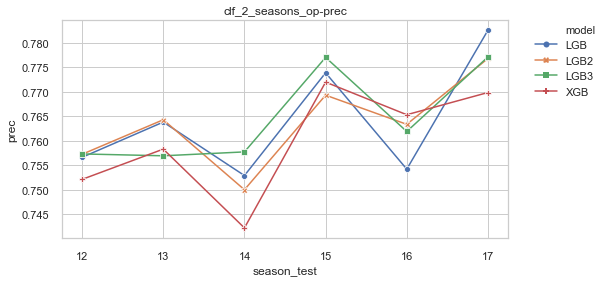

In [37]:
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))
name, res = get_result_by(experiment_name[:-3])

res = [x for x in res if x['model'][0] in model_names] 
plot_results(name[:-3], res, figsize=(8,4))

### Final validation

#### Dataset

In [15]:
fv_df = season_games[(season_games.SEASON >= 2016)]

##### Seasons

In [16]:
fv_df.SEASON.unique()

array([2016, 2017, 2018, 2019])

##### clean data

In [17]:
print(fv_df.shape)
fv_df = fv_df.dropna()
print(fv_df.isnull().sum().sum())
print(fv_df.isna().sum().sum())
print(fv_df.shape)

(4749, 261)
0
0
(4685, 261)


#### setup

In [18]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_final_validation"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

fv_models = utils_exp.get_clf_models()

fv_sscv = utils.SeasonSeriesSplit(fv_df)
fv_df_sscv = fv_sscv.get_df()
fv_X = fv_df_sscv[exp_X_columns]
fv_y = fv_df_sscv[TARGET]

#### experiment

In [19]:
experiment_name = f"{exp_prefix}2_seasons_fv"

In [20]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = fv_sscv.split(train_size=2, test_size=1)
params = (experiment_name, fv_models, folds, train_seasons, test_seasons, fv_X, fv_y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_fv
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
4,clf_2_seasons_fv,RF,0.762396,0.033825,0.738084,0.020561
3,clf_2_seasons_fv,SVM,0.761851,0.029544,0.745272,0.016139
0,clf_2_seasons_fv,L2R,0.757738,0.028254,0.742014,0.013661
6,clf_2_seasons_fv,LGB,0.749895,0.025701,0.716310,0.007497
5,clf_2_seasons_fv,XGB,0.741749,0.025189,0.711492,0.009271
2,clf_2_seasons_fv,DT,0.700006,0.008087,0.650257,0.012661
1,clf_2_seasons_fv,KNN,0.659587,0.024073,0.613094,0.007160


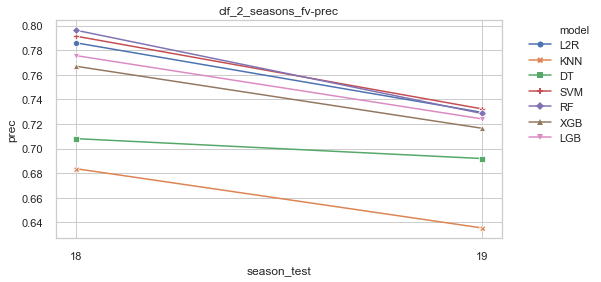

In [21]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))